In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import norm
from gp_dev.core import *
from ddop.datasets import load_yaz
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = load_yaz(encode_date_features=True, include_prod=['STEAK']).frame

In [16]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2, ard_num_dims=29)
        #self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def nv_cost(q, y, cu, co):
    if q>y:
        cost = (q-y)*co
    else:
        cost = (y-q)*cu
    return cost


In [3]:
res = []

In [5]:
for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
    
    df = load_yaz(encode_date_features=True, include_prod=[target]).frame
    
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    data = torch.tensor(df_scaled, dtype=torch.float32)
    
    N = data.shape[0]
    # make train/val/test
    #n_train = int(0.8 * N)
    n_train = 600 #
    #n_train = int(1 * N)
    train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
    test_x, test_y = data[n_train:, :-1], data[n_train:, -1]
    
    # make continguous
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    output_device = torch.device('cuda:0')

    train_x, train_y = train_x.to(output_device), train_y.to(output_device)
    test_x, test_y = test_x.to(output_device), test_y.to(output_device)

    n_devices = torch.cuda.device_count()
    print('Planning to run on {} GPUs.'.format(n_devices))
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()
    model.covar_module.initialize_from_data(train_x, train_y)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = likelihood(model(test_x))
        
    y_train_unscaled = scaler.inverse_transform(df_scaled[:n_train,:])[:,-1]
    y_test_unscaled = scaler.inverse_transform(df_scaled[n_train:,:])[:,-1]
    
    n_features = df_scaled.shape[1]
    nv_means = observed_pred.mean.cpu().numpy()
    nv_means_unscaled = scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1]

    nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
    nv_sigma_unscaled = scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1]
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
        nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
        cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp_spectral", "target": target})
        res.append(ser_tmp)
    
df_res = pd.DataFrame(res)

Planning to run on 1 GPUs.
Iter 1/100 - Loss: 0.844
Iter 2/100 - Loss: 0.791
Iter 3/100 - Loss: 0.748
Iter 4/100 - Loss: 0.714
Iter 5/100 - Loss: 0.679
Iter 6/100 - Loss: 0.637
Iter 7/100 - Loss: 0.593
Iter 8/100 - Loss: 0.549
Iter 9/100 - Loss: 0.508
Iter 10/100 - Loss: 0.469
Iter 11/100 - Loss: 0.428
Iter 12/100 - Loss: 0.384
Iter 13/100 - Loss: 0.338
Iter 14/100 - Loss: 0.294
Iter 15/100 - Loss: 0.253
Iter 16/100 - Loss: 0.211
Iter 17/100 - Loss: 0.165
Iter 18/100 - Loss: 0.119
Iter 19/100 - Loss: 0.076
Iter 20/100 - Loss: 0.034
Iter 21/100 - Loss: -0.010
Iter 22/100 - Loss: -0.056
Iter 23/100 - Loss: -0.098
Iter 24/100 - Loss: -0.139
Iter 25/100 - Loss: -0.182
Iter 26/100 - Loss: -0.224
Iter 27/100 - Loss: -0.263
Iter 28/100 - Loss: -0.304
Iter 29/100 - Loss: -0.342
Iter 30/100 - Loss: -0.378
Iter 31/100 - Loss: -0.416
Iter 32/100 - Loss: -0.449
Iter 33/100 - Loss: -0.483
Iter 34/100 - Loss: -0.514
Iter 35/100 - Loss: -0.543
Iter 36/100 - Loss: -0.570
Iter 37/100 - Loss: -0.595
Ite

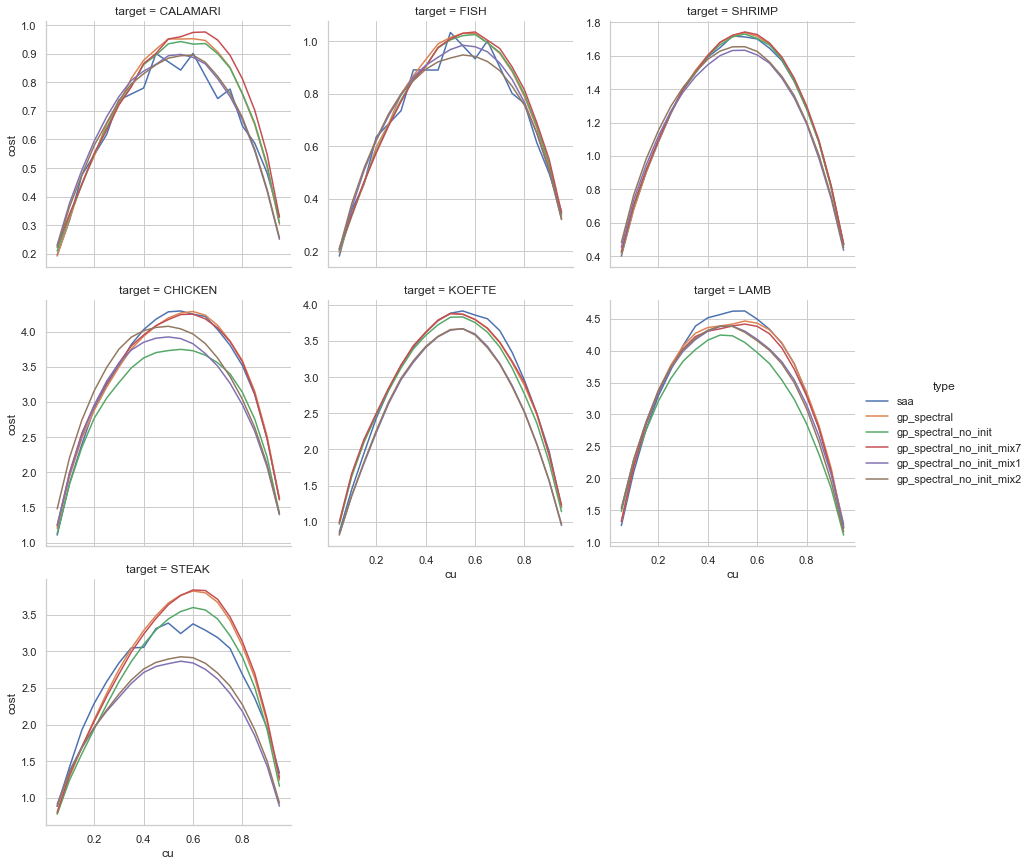

In [18]:
df_plot = df_res
sns.set(rc={'figure.figsize':(15,15)})
sns.set_style('whitegrid')
sns.relplot(data=df_plot, x="cu", y="cost",col_wrap=3,facet_kws={'sharey':False},
    col="target", hue="type",kind="line", aspect=1, height=4); 


In [17]:
for target in ['CALAMARI', 'FISH', 'SHRIMP', 'CHICKEN', 'KOEFTE', 'LAMB', 'STEAK']:
    
    df = load_yaz(encode_date_features=True, include_prod=[target]).frame
        
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    data = torch.tensor(df_scaled, dtype=torch.float32)
    
    N = data.shape[0]
    # make train/val/test
    #n_train = int(0.8 * N)
    n_train = 600 #
    #n_train = int(1 * N)
    train_x, train_y = data[:n_train, :-1], data[:n_train, -1]
    test_x, test_y = data[n_train:, :-1], data[n_train:, -1]
    
    # make continguous
    train_x, train_y = train_x.contiguous(), train_y.contiguous()
    test_x, test_y = test_x.contiguous(), test_y.contiguous()

    output_device = torch.device('cuda:0')

    train_x, train_y = train_x.to(output_device), train_y.to(output_device)
    test_x, test_y = test_x.to(output_device), test_y.to(output_device)

    n_devices = torch.cuda.device_count()
    print('Planning to run on {} GPUs.'.format(n_devices))
    
    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = SpectralMixtureGPModel(train_x, train_y, likelihood).cuda()
    #model.covar_module.initialize_from_data(train_x, train_y)

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    training_iter = 100

    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step()
        
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
    # See https://arxiv.org/abs/1803.06058
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Make predictions
        observed_pred = likelihood(model(test_x))
        
    y_train_unscaled = scaler.inverse_transform(df_scaled[:n_train,:])[:,-1]
    y_test_unscaled = scaler.inverse_transform(df_scaled[n_train:,:])[:,-1]
    
    n_features = df_scaled.shape[1]
    nv_means = observed_pred.mean.cpu().numpy()
    nv_means_unscaled = scaler.inverse_transform(np.stack([nv_means for i in range(n_features)], axis=1))[:,-1]

    nv_sigma = np.sqrt(torch.diag(observed_pred.covariance_matrix).cpu().detach().numpy())
    nv_sigma_unscaled = scaler.inverse_transform(np.stack([nv_sigma for i in range(n_features)], axis=1))[:,-1]
    
    for c in range(5,100, 5):
        cu = c/100
        co = 1-cu
        nv_quantile = np.quantile(y_train_unscaled, q=cu/(cu+co))
        nv_solution = nv_means_unscaled+norm.ppf(cu/(cu+co))*nv_sigma_unscaled
        #cost_saa = np.mean([nv_cost(nv_quantile, y, cu, co) for y in y_test_unscaled])
        cost_gp =  np.mean([nv_cost(q, y, cu, co) for q, y in zip(nv_solution, y_test_unscaled)])
        #ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_saa, "type":"saa", "target": target})
        #res.append(ser_tmp)
        ser_tmp=pd.Series({"cu":cu, "co":co, "cost":cost_gp, "type":"gp_spectral_no_init_mix2", "target": target})
        res.append(ser_tmp)
    
df_res = pd.DataFrame(res)

Planning to run on 1 GPUs.
Iter 1/100 - Loss: 1.265
Iter 2/100 - Loss: 1.219
Iter 3/100 - Loss: 1.175
Iter 4/100 - Loss: 1.133
Iter 5/100 - Loss: 1.088
Iter 6/100 - Loss: 1.041
Iter 7/100 - Loss: 0.992
Iter 8/100 - Loss: 0.942
Iter 9/100 - Loss: 0.892
Iter 10/100 - Loss: 0.841
Iter 11/100 - Loss: 0.789
Iter 12/100 - Loss: 0.736
Iter 13/100 - Loss: 0.681
Iter 14/100 - Loss: 0.626
Iter 15/100 - Loss: 0.571
Iter 16/100 - Loss: 0.515
Iter 17/100 - Loss: 0.460
Iter 18/100 - Loss: 0.405
Iter 19/100 - Loss: 0.349
Iter 20/100 - Loss: 0.294
Iter 21/100 - Loss: 0.239
Iter 22/100 - Loss: 0.186
Iter 23/100 - Loss: 0.133
Iter 24/100 - Loss: 0.080
Iter 25/100 - Loss: 0.028
Iter 26/100 - Loss: -0.022
Iter 27/100 - Loss: -0.070
Iter 28/100 - Loss: -0.118
Iter 29/100 - Loss: -0.165
Iter 30/100 - Loss: -0.210
Iter 31/100 - Loss: -0.253
Iter 32/100 - Loss: -0.295
Iter 33/100 - Loss: -0.334
Iter 34/100 - Loss: -0.372
Iter 35/100 - Loss: -0.408
Iter 36/100 - Loss: -0.441
Iter 37/100 - Loss: -0.471
Iter 38/